# Time Series Forecasting

In this lab, we experiment two of the most popular models for time
series forecasting as well as several visualization techniques for data exploration. 

## Data Preparation & Cleaning

In [1]:
# load and plot the car sales dataset
from pandas import read_csv
from matplotlib import pyplot
# load data (monthly sales)
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
# use datetime (the Month column) as index
df = read_csv(path, header=0)
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   108 non-null    object
 1   Sales   108 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


As you can see above, the Month column is of type object. Lets convert it to datetime.

In [3]:
from datetime import datetime
import pandas as pd
# we have to provide the format for date %Y is year, %m is month, %d is day.
df['Month'] = df.Month.apply(lambda x: datetime.strptime(x, "%Y-%m").date())
df['Month'] = pd.to_datetime(df['Month'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   108 non-null    datetime64[ns]
 1   Sales   108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


Now it shows that the Month column is of type datetime.

This dataset does not have any missing values. But if any, typically for time series data we either drop them or fill them with the last valid observations to fill gaps.

```python
# ffill is used to replace the missing value with the last observation
df = df.fillna(method='ffill')
df.head()
```

## Visualization

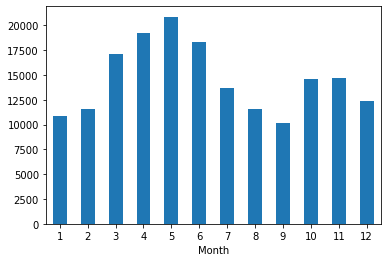

In [5]:
# plot the time series (monthly sale, the data was in month any way)
df.groupby(df["Month"].dt.month)["Sales"].mean().plot(
    kind='bar', rot=0, 
)
pyplot.show()

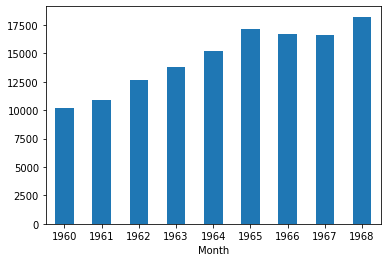

In [6]:
# plot the time series (yearly average sale)
df.groupby(df["Month"].dt.year)["Sales"].mean().plot(
    kind='bar', rot=0, 
)
pyplot.show()

In [7]:
# any other way to zoom in/zoom out on the time scale by resample. 
# But we have to set Month (the datetime) column as index.
df_3m = df.set_index('Month')
# aggregation based on 3 months
df_3m.resample('3M').mean().head()

,Sales
Month,
1960-01-31,6550.000000
1960-04-30,11716.333333
1960-07-31,12625.333333
1960-10-31,8281.666667
1961-01-31,8352.333333


In [8]:
# aggregation based on 2 years
df_3m.resample('2Y').mean().head()

,Sales
Month,
1960-12-31,10186.666667
1962-12-31,11760.708333
1964-12-31,14499.000000
1966-12-31,16920.208333
1968-12-31,17404.750000


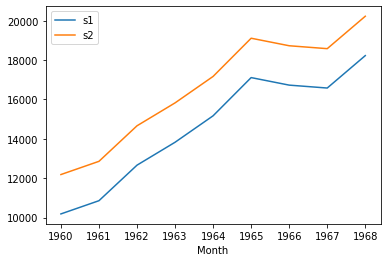

In [9]:
# Comparing multiple time series
import matplotlib.pyplot as plt
s1 = df.groupby(df["Month"].dt.year)["Sales"].mean()
s2 = df.groupby(df["Month"].dt.year)["Sales"].mean() + 2000
s1.plot()
s2.plot()
plt.legend(['s1','s2'])
plt.show()

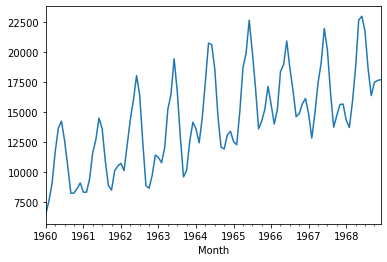

In [10]:
# Rolling 90D average
rolling_df = df.set_index('Month')
rolling_df.Sales.rolling('90D').mean().plot()
plt.show()

## Autocorrelation and Partial Autocorrelation

- Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.

- Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


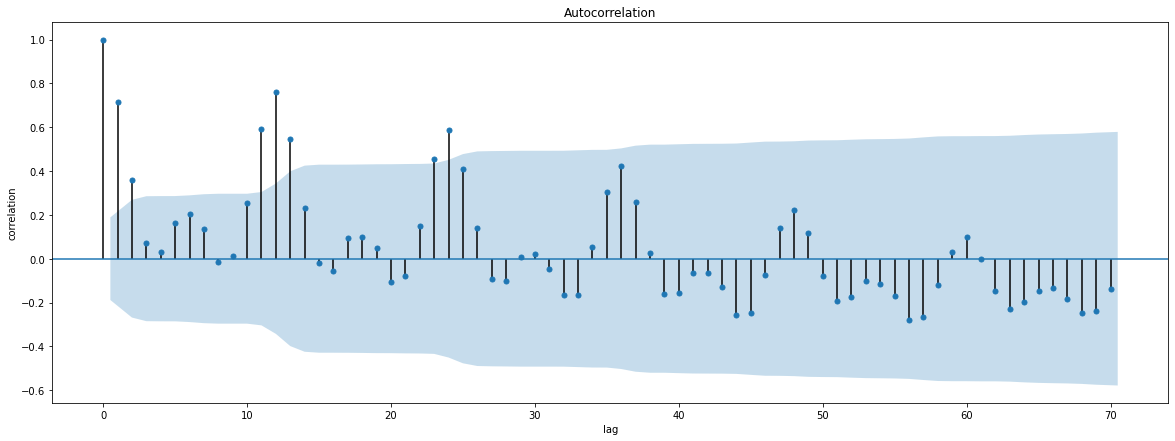

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

acf_plot = plot_acf(df.Sales, lags = 70)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

All the lags have a value between -1 and 1. Some of them are greater than the confierence interval (.05).

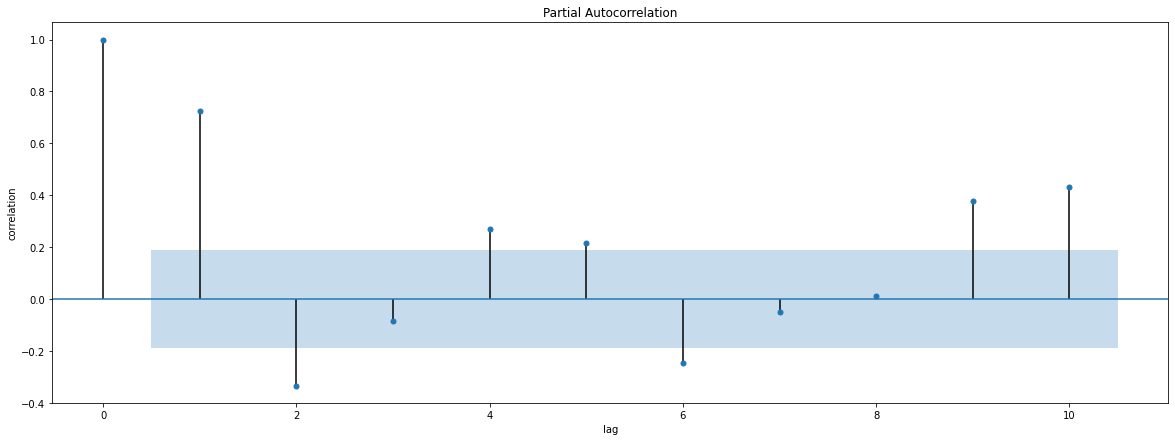

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

acf_plot = plot_pacf(df.Sales, lags = 10)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

Though it is statistically signficant, partial autocorrelation after first 2 lags is very low. Let see what kind of seasonality pattern we can find.

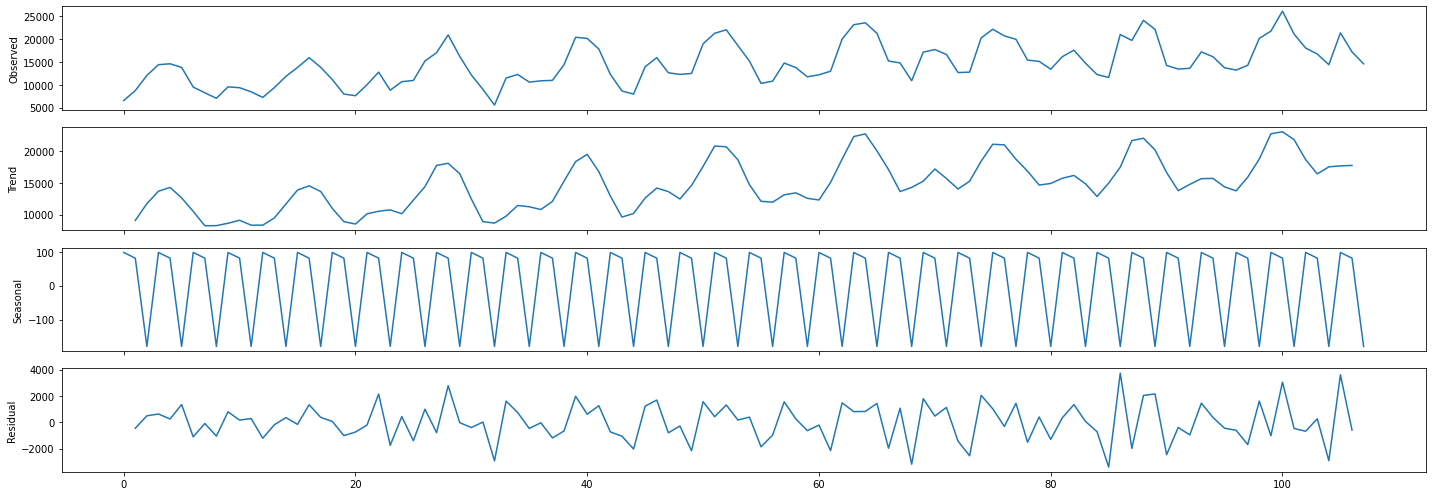

In [13]:
# Let's try decompose the time series with a quarter (3 Months) seasonality

import statsmodels.api as sm

decomposed_sales = sm.tsa.seasonal_decompose(
    df.Sales, freq=3) # The frequncy is quarter
figure = decomposed_sales.plot()
plt.show()

Using 3-month period as seasonality, the residual is not stationary and the trend still seems still seasonal. Let's try yearly. 

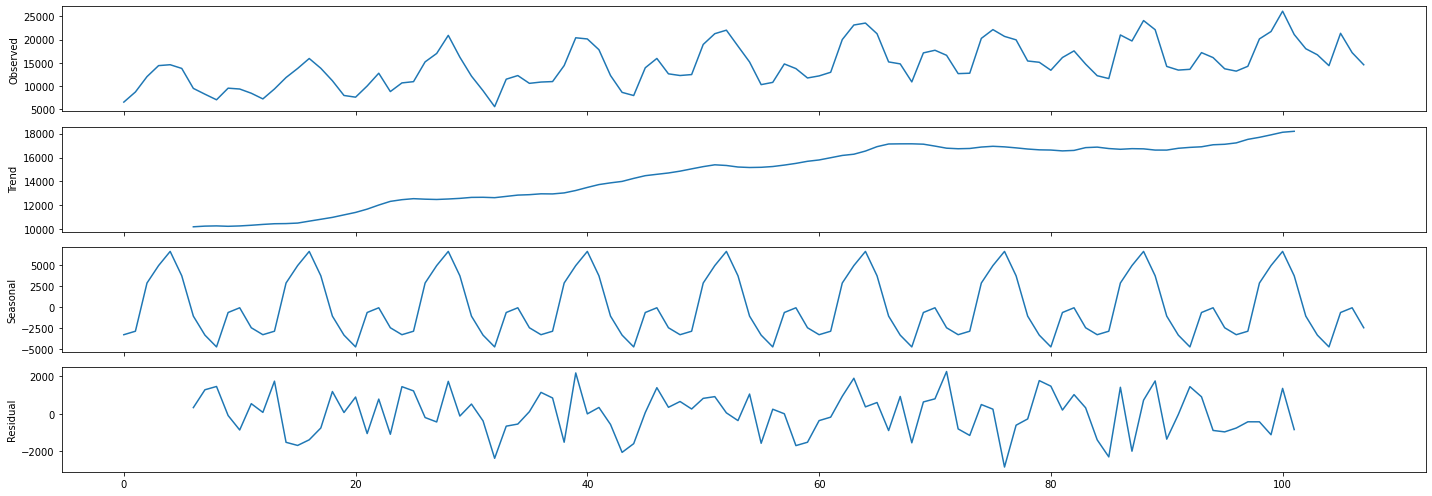

In [14]:
# Let's try decompose the time series with a yearly (12 Months) seasonality
decomposed_sales = sm.tsa.seasonal_decompose(
    df.Sales, freq=12) # The frequncy is annual
figure = decomposed_sales.plot()
plt.show()

Clearly now we can see a yearly pattern and a stationary residual. This example is a straightforward case, but a lot of real-life time series contain mulitple seaionality/cylic patterns with change points in trends.

## ARIMA 

With the ARIMA model, typically we have to determine:

- the order of differencing
- the order of AR
- the order of MA



### The order of differencing

We can start from adfuller to check if ordering will make a difference in correlation.

In [15]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df.Sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -1.223813
p-value: 0.663269


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.Sales); axes[0, 0].set_title('Original Series')
plot_acf(df.Sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Sales.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.Sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Sales.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

We focus mainly for the charts on the left. The time series reaches stationarity with 1-2 orders of differencing. For now, we can start with the order of differing from 1. 

### The order of AR. 

Earlier we use partial autocorrelation for data exploration. It will help us to determine the order of AR (number of lags useful for prediction). Lets plot it again here:


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

acf_plot = plot_pacf(df.Sales, lags = 10)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

As we can see, most of the lags > confidence interval. But lag 1 and 2 seems the most effective without going too far. We can try to start with 2, but tunable with higher order. 

### The order of MA. 

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms (the residu

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.Sales.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.Sales.diff().dropna(), ax=axes[1])

plt.show()

Overall residuals doesn't seem to be very helpful. There is one in the middle around 13. But we have to cover anything before that. We can try 0 or [10-20].

### Model training (Out-of-Time Cross validation)

Lets start by splitting the data based on time and training a model.

In [ ]:
import statsmodels.api as sm

df_ar = df.copy()

train = df_ar.Sales[:96]
test = df_ar.Sales[96:]

# order = (p, d, q) 
model = sm.tsa.ARMA(train, (1, 2, 0))
model_fit = model.fit()
model_fit.summary()

Let's see how well it fits to the training set by sploting the distribution and density of the residual erros.

In [ ]:
# Plot residual errors
import pandas as pd

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
model_fit.plot_predict(dynamic=False)
plt.show()

Both curves look very similar in terms of the pattern. However, it is clear that forecast is slightly delayed compared to the original series, meaning that it heavily relies on the previous value for prediction but the yearly seasonality is not well-captured (or removed by the differing mechanism).

Lets try the model on the testing set.

In [ ]:
# Forecast
fc, se, conf = model_fit.forecast(12, alpha=0.9)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

It further shows that the seasonality of the time series is not well modelled. 

## Prophet

Next, lets try to use the prophet library.

### Preparing inputs

In [ ]:
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot


# prophet requires fixed name of columns. 
# ds -> datetime
# y -> values

df_pp = df.copy()
df_pp.columns = ['ds', 'y']
df_pp['ds'] = to_datetime(df_pp['ds'])
df_pp.head()

In [ ]:
# split!
train_pp = df_pp[:96]
test_pp = df_pp[96:]

### Training & Prediction

In [ ]:
# define the model
model = Prophet()
# fit the model
model.fit(df_pp)

In [ ]:
# get the prediction dates
future = test_pp
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

### What does it learn?

We can plot the decomposed components from the model.

In [ ]:
model.plot_components(forecast)

In [ ]:
# plot change points in the trend.
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)


References:

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.kaggle.com/code/eneszvo/time-series-forecasting-es-arima-var#Stationarity

https://www.kaggle.com/code/thebrownviking20/everything-you-can-do-with-a-time-series/notebook